## Goals

Here, I try to replicate R's *fda* basic functionality myself. I'm doing this because I'm following along with chapter 9 of the book *Functional Data Analysis with R and MATLAB*, but some code examples aren't working. Let's do some things from scratch!

Note: I don't want to spend copious amounts of time reinventing the wheel with basis function fitting, so I'll trust that *scikit-fda* is able to do that correctly.

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import skfda
from skfda.datasets import fetch_weather

## Download the data

In [2]:
X, regions = fetch_weather(return_X_y=True, as_frame=True)

## Get and visualize temperature curves

In [3]:
temps = X.iloc[:,0].values.coordinates[0]

In [4]:
temps

FDataGrid(
    array([[[ -3.6],
            [ -3.1],
            [ -3.4],
            ...,
            [ -3.2],
            [ -2.8],
            [ -4.2]],
    
           [[ -4.4],
            [ -4.2],
            [ -5.3],
            ...,
            [ -3.6],
            [ -4.9],
            [ -5.7]],
    
           [[ -3.8],
            [ -3.5],
            [ -4.6],
            ...,
            [ -3.4],
            [ -3.3],
            [ -4.8]],
    
           ...,
    
           [[-23.3],
            [-24. ],
            [-24.4],
            ...,
            [-23.5],
            [-23.9],
            [-24.5]],
    
           [[-26.3],
            [-27.1],
            [-27.8],
            ...,
            [-25.7],
            [-24. ],
            [-24.8]],
    
           [[-30.7],
            [-30.6],
            [-31.4],
            ...,
            [-29. ],
            [-29.4],
            [-30.5]]], shape=(35, 365, 1)),
    grid_points=(array([  0.5,   1.5,   2.5,   3.5,   4.5

We plot each temperature curve and color based on region.

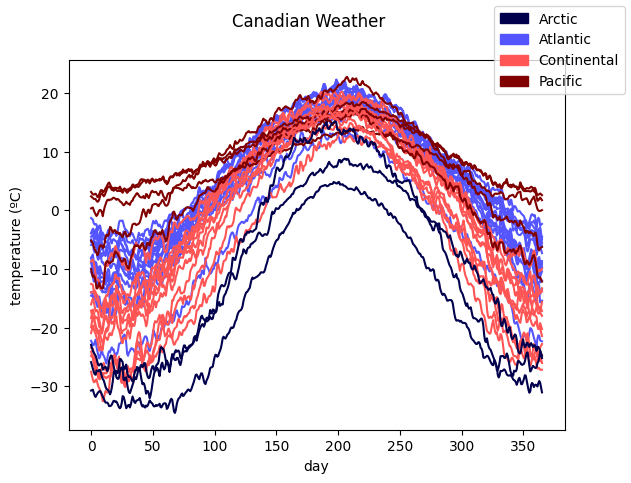

In [5]:
# Each climate is assigned a color. Defaults to grey.
colormap = matplotlib.colormaps['seismic']
label_names = regions.values.categories
nlabels = len(label_names)
label_colors = colormap(np.arange(nlabels) / (nlabels - 1))

temps.plot(group=regions.values.codes,
                     group_colors=label_colors,
                     group_names=label_names)
plt.show()

## Get and visualize log total annual precipitation

In [6]:
precipitation = X.iloc[:,0].values.coordinates[1]
# total_precipitation = np.array([fd.integrate() for fd in precipitation])
total_precipitation = np.array([
    fd.data_matrix[0].sum()
    for fd in precipitation
])
prec = np.log10(total_precipitation).ravel()

In [7]:
prec

array([3.17049641, 3.16286299, 3.16861532, 3.10123139, 3.07979606,
       3.0522706 , 2.90374094, 2.95259873, 2.96913623, 3.08228259,
       3.04504901, 2.97349731, 2.96032805, 2.89353984, 2.98136551,
       2.84775769, 2.70688839, 2.65234306, 2.61151089, 2.56949095,
       2.60916737, 2.55954756, 2.66763971, 2.60260252, 2.43440921,
       3.06261958, 2.93023565, 2.78454597, 3.41360149, 2.43408964,
       2.51547644, 2.42829681, 2.61752453, 2.41514035, 2.15836249])

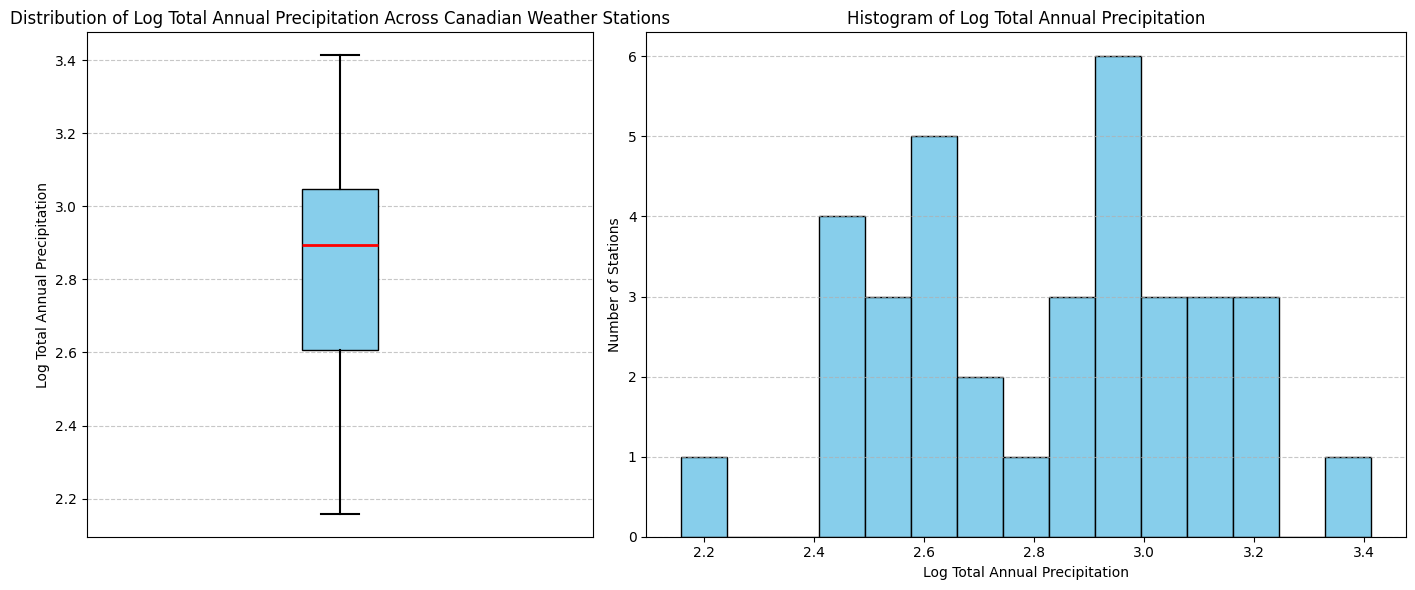

In [8]:
# --- Boxplot + Histogram Side by Side ---
fig, axes = plt.subplots(1, 2, figsize=(14, 6), gridspec_kw={'width_ratios': [1, 1.5]})

# --- Boxplot (unchanged) ---
axes[0].boxplot(prec, patch_artist=True,
                boxprops=dict(facecolor='skyblue', color='black'),
                medianprops=dict(color='red', linewidth=2),
                whiskerprops=dict(color='black', linewidth=1.5),
                capprops=dict(color='black', linewidth=1.5),
                flierprops=dict(marker='o', markerfacecolor='orange', markersize=6, linestyle='none'))

axes[0].set_ylabel("Log Total Annual Precipitation")
axes[0].set_title("Distribution of Log Total Annual Precipitation Across Canadian Weather Stations")
axes[0].grid(axis='y', linestyle='--', alpha=0.7)
axes[0].set_xticks([])

# --- Histogram ---
axes[1].hist(prec, bins=15, color='skyblue', edgecolor='black')
axes[1].set_xlabel("Log Total Annual Precipitation")
axes[1].set_ylabel("Number of Stations")
axes[1].set_title("Histogram of Log Total Annual Precipitation")
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


## Visualize temperature curves colored by log precipitation

In [9]:
norm = matplotlib.colors.Normalize(
    vmin=prec.min(),
    vmax=prec.max()
)

# Each climate is assigned a color. Defaults to grey.
colormap = matplotlib.colormaps['seismic']
curve_colors = colormap(norm(prec))

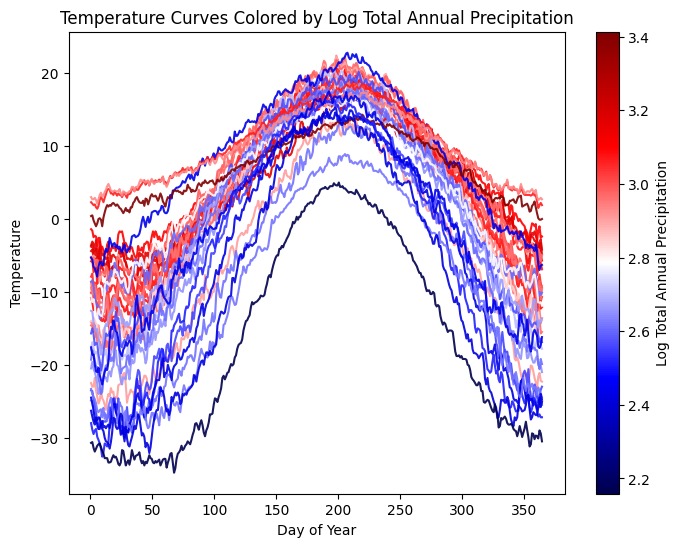

In [10]:
from matplotlib.cm import ScalarMappable

# --- Plot each temperature curve individually ---
plt.figure(figsize=(8, 6))
ax = plt.gca()

for i in range(temps.n_samples):
    plt.plot(
        temps.grid_points[0],
        temps.data_matrix[i, :, 0],
        color=curve_colors[i],
        alpha=0.9
    )

plt.xlabel("Day of Year")
plt.ylabel("Temperature")
plt.title("Temperature Curves Colored by Log Total Annual Precipitation")

# --- Colorbar ---
sm = ScalarMappable(norm=norm, cmap=colormap)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label("Log Total Annual Precipitation")

plt.show()

## Low-dimensional regression coefficient function $\beta$

### Computations

Here, we'll use the naive functional linear regression method of taking $X(t)$, projecting it onto a Fourier basis consisting of 65 smooth functions, and getting 5 Fourier coefficients for $\beta(t)$.

First, we smooth each $X(t)$ using this 65-Fourier basis. This matches the code from R.

In [11]:
X_fourier_basis = skfda.representation.basis.FourierBasis(domain_range=(0, 364), n_basis=65, period=365)
temps_fourier = temps.to_basis(X_fourier_basis)
temps_fourier

FDataBasis(
    basis=FourierBasis(domain_range=((0.0, 364.0),), n_basis=65, period=365),
    coefficients=[[ 8.95997071e+01 -7.46767265e+01 -1.15178878e+02 ... -1.85078404e+00
      -2.45385324e-01 -2.03142842e-01]
     [ 1.17492968e+02 -7.57467309e+01 -1.49740294e+02 ... -7.18334416e-01
       1.03821301e+00 -4.92819113e-02]
     [ 1.05260551e+02 -8.51564381e+01 -1.37094408e+02 ... -3.82405843e-01
       2.23484427e-01 -4.71703877e-01]
     ...
     [-1.84412716e+02 -1.21877497e+02 -2.11146490e+02 ... -2.14488938e+00
      -1.26675669e+00  3.31450785e-01]
     [-1.76529952e+02 -9.89647904e+01 -2.85793010e+02 ...  5.55250315e-01
       4.37801328e-01  5.64483509e-01]
     [-3.15582751e+02 -1.11608834e+02 -2.33472816e+02 ... -5.36388716e-01
      -5.46798393e-01 -2.60371925e+00]],
    dataset_name=Canadian Weather,
    argument_names=('day',),
    coordinate_names=(np.str_('temperature (ºC)'),),
    extrapolation=None)

Generate the $\beta$ 5-Fourier basis.

In [12]:
beta_fourier_basis = skfda.representation.basis.FourierBasis(domain_range=(0, 364), n_basis=5, period=365)

Compute the $65 \times 5$ $L_{2}$ inner product matrix $J_{\psi \theta}$. The R version seems to match when we use the identity matrix for $J$ instead of the numeric integration matrix.

In [13]:
# J = X_fourier_basis.inner_product_matrix(beta_fourier_basis)
J = np.eye(65, 5)

print(J.shape)
print(J)

(65, 5)
[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [

Construct the matrix $Z$ by prepending a column of ones.

In [14]:
Z = np.concatenate((np.ones((35, 1)), temps_fourier.coefficients @ J), axis=1)
# Z = temps_fourier.coefficients @ J
print(Z.shape)
print(Z)

(35, 6)
[[   1.           89.59970707  -74.67672652 -115.17887797    5.5320409
     4.23416905]
 [   1.          117.4929679   -75.74673091 -149.74029437   -1.13008872
    -1.09430222]
 [   1.          105.26055083  -85.1564381  -137.09440756    0.52842204
     4.44785457]
 [   1.          130.13365563  -66.01326886 -119.05187489   -2.5295573
    -3.9210933 ]
 [   1.           99.96350074  -83.87111523 -158.92545942   -4.33875191
    -0.46197323]
 [   1.          100.54973553  -70.21953795 -181.62659749   -7.28576657
    -6.63228477]
 [   1.          -96.65546155  -98.06174409 -221.18086933   -9.34989482
    -7.90683222]
 [   1.           59.22541684  -76.58496254 -211.48216031  -17.35179818
   -14.95425479]
 [   1.           42.91552741  -75.88594192 -213.56471876  -16.79521918
   -14.60033008]
 [   1.           77.96399327  -73.32390869 -200.18276086  -13.16131373
    -9.01383237]
 [   1.           78.702021    -67.46233198 -188.11022053  -15.10706906
   -10.77893449]
 [   1.        

Compute the estimated coefficient vector $\hat{\zeta}$ via the equation
$$Z'Z \hat{\zeta} = Z'y,$$
which has solution
$$\hat{\zeta} = (Z'Z)^{-1}Z'y.

In [15]:
zeta_hat = np.linalg.inv(Z.T @ Z) @ Z.T @ prec
print("Intercept:", zeta_hat[0])
print("Coefficients:", zeta_hat[1:])

Intercept: 3.4648445357457325
Coefficients: [ 0.00060118 -0.00142849  0.00418457 -0.01608142  0.00280403]


We get really close to the coefficients! However, the intercept term is pretty off.

### Plots

Next, we'll plot the coefficient function.

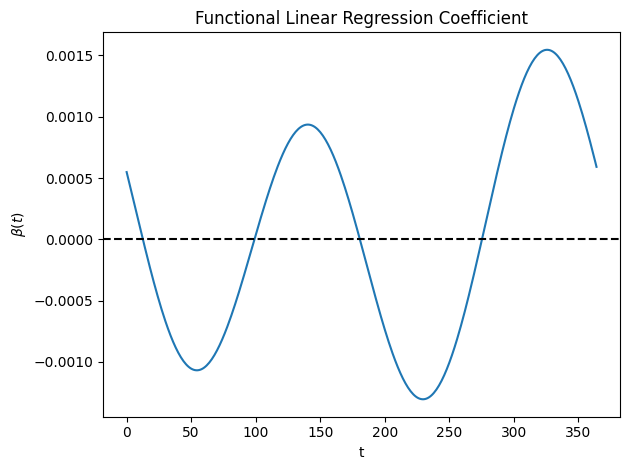

In [16]:
# Create an array consisting of the days in the year as defined by the basis.
day_array = np.linspace(*beta_fourier_basis.domain_range[0], 365)

# Evaluate the basis functions at each day of the year.
Phi = beta_fourier_basis(day_array)
Phi = Phi[..., 0] # Shape: (5, 365)

# Take the appropriate linear combination as defined above.
beta_values = zeta_hat[1:] @ Phi

plt.figure()
plt.plot(day_array, beta_values)
plt.axhline(0, c="black", linestyle="--")
plt.xlabel("t")
plt.ylabel(r"$\beta(t)$")
plt.title("Functional Linear Regression Coefficient")
plt.tight_layout()
plt.show()

What does $X_{1}(t) \cdot \beta(t)$ look like? This is the function that is integrated and summed with $\alpha$ in the functional linear regression model.

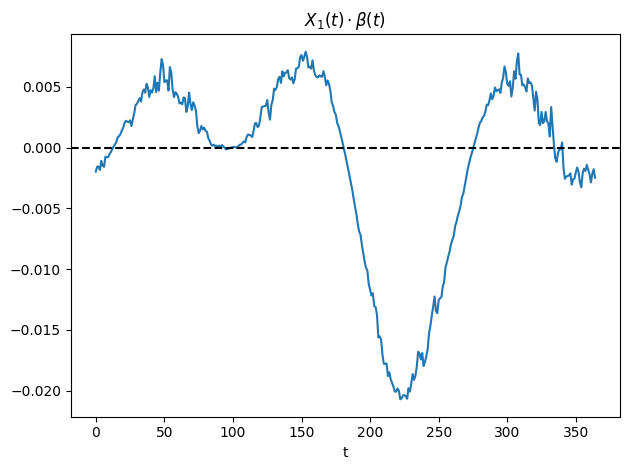

In [17]:
contributions = temps.data_matrix[0,:,0] * beta_values

plt.figure()
plt.plot(day_array, contributions)
plt.axhline(0, c="black", linestyle="--")
plt.xlabel("t")
# plt.ylabel(r"$\beta(t)$")
plt.title(r"$X_{1}(t) \cdot \beta(t)$")
plt.tight_layout()
plt.show()

### Fit assessment

We compute $R^{2}$ on the whole data set and the $F$-score.

Residuals:
$$\hat{y} = Z \hat{\zeta}$$

In [18]:
prec_hat = Z @ zeta_hat
prec_res = prec - prec_hat

Recall the equation for $R^{2}$:
$$R^{2} = 1 - \frac{SS_{Res}}{SS_{Total}}$$

In [19]:
SS_tot = np.sum((prec - prec.mean())**2)
SS_res = np.sum(prec_res**2)

R2 = 1 - SS_res/SS_tot
R2

np.float64(0.7955986271081688)

$R^{2}$ matches exactly!

Recall the equation for the $F$ statistic with $n$ observations and $p$ predictors:
$$F = \frac{(SS_{T}-SS_{Res})/p}{SS_{Res}/(n-p-1)}.$$
This also matches exactly!

In [20]:
F = ((SS_tot - SS_res) / 5) / (SS_res / (35 - 5 - 1))
F

np.float64(22.575543265403354)

### Remarks: A- reproducbility

This demonstrates that, save for the intercept, everything in the regularization using restricted basis functions method is fully reproducible!

## Coefficient $\beta$ estimate using a roughness penalty

Here, we'll use the more advanced functional linear regression method of taking $X(t)$, projecting it onto a Fourier basis consisting of 65 smooth functions, and getting 35 Fourier coefficients for $\beta(t)$ using a roughness penalty.

### Computations

Again, we smooth each $X(t)$ using this 65-Fourier basis. This matches the code from R.

In [74]:
X_fourier_basis = skfda.representation.basis.FourierBasis(domain_range=(0, 364), n_basis=65, period=365)
temps_fourier = temps.to_basis(X_fourier_basis)
temps_fourier

FDataBasis(
    basis=FourierBasis(domain_range=((0.0, 364.0),), n_basis=65, period=365),
    coefficients=[[ 8.95997071e+01 -7.46767265e+01 -1.15178878e+02 ... -1.85078404e+00
      -2.45385324e-01 -2.03142842e-01]
     [ 1.17492968e+02 -7.57467309e+01 -1.49740294e+02 ... -7.18334416e-01
       1.03821301e+00 -4.92819113e-02]
     [ 1.05260551e+02 -8.51564381e+01 -1.37094408e+02 ... -3.82405843e-01
       2.23484427e-01 -4.71703877e-01]
     ...
     [-1.84412716e+02 -1.21877497e+02 -2.11146490e+02 ... -2.14488938e+00
      -1.26675669e+00  3.31450785e-01]
     [-1.76529952e+02 -9.89647904e+01 -2.85793010e+02 ...  5.55250315e-01
       4.37801328e-01  5.64483509e-01]
     [-3.15582751e+02 -1.11608834e+02 -2.33472816e+02 ... -5.36388716e-01
      -5.46798393e-01 -2.60371925e+00]],
    dataset_name=Canadian Weather,
    argument_names=('day',),
    coordinate_names=(np.str_('temperature (ºC)'),),
    extrapolation=None)

Generate the $\beta$ 35-Fourier basis.

In [75]:
beta_fourier_basis = skfda.representation.basis.FourierBasis(domain_range=(0, 364), n_basis=35, period=365)

Compute the $65 \times 35$ $L_{2}$ inner product matrix $J_{\psi \theta}$. The R version seems to match when we use the identity matrix for $J$ instead of the numeric integration matrix.

In [76]:
# J = X_fourier_basis.inner_product_matrix(beta_fourier_basis)
J = np.eye(65, 35)

print(J.shape)
print(J)

(65, 35)
[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


Construct the matrix $Z$ by prepending a column of ones.

In [77]:
Z = np.concatenate((np.ones((35, 1)), temps_fourier.coefficients @ J), axis=1)
# Z = temps_fourier.coefficients @ J
print(Z.shape)
print(Z)

(35, 36)
[[ 1.00000000e+00  8.95997071e+01 -7.46767265e+01 ... -1.09559400e+00
  -2.38774045e-02  7.01939423e-01]
 [ 1.00000000e+00  1.17492968e+02 -7.57467309e+01 ...  8.75222485e-01
   1.92850793e+00  8.98349981e-01]
 [ 1.00000000e+00  1.05260551e+02 -8.51564381e+01 ...  1.18948405e-01
   9.97910037e-01  4.69595494e-01]
 ...
 [ 1.00000000e+00 -1.84412716e+02 -1.21877497e+02 ...  8.38557886e-01
   6.63518605e-01  1.61832226e+00]
 [ 1.00000000e+00 -1.76529952e+02 -9.89647904e+01 ... -5.13223297e-01
  -3.25554509e+00  1.43545417e+00]
 [ 1.00000000e+00 -3.15582751e+02 -1.11608834e+02 ... -1.57342169e+00
  -4.95704018e-01  1.96891353e+00]]


New here, we need to compute the penalty matrix $R$ and its modification $R_{0}$ (add a leading row and column of zeros):

$$R = \int [D^{2} \phi(s)][D^{2} \phi'(s)] \,ds.$$

Here, since we use the Fourier basis, $R$ is diagonal with diagonal elements all 1.

In [78]:
# R = np.eye(35)
# R = np.diag((beta_fourier_basis.derivative(order=2)(day_array)[:,:,0]**2).sum(axis=1) * 365/(2*np.pi))
L = 365
omegas = [0] + [((((k+1)//2) / L)**4) for k in range(1, 35)]
R = np.diag(omegas)
R_0 = np.concatenate((np.zeros((35, 1)), R), axis=1)
R_0 = np.concatenate((np.zeros((1, 36)), R_0), axis=0)
R_0

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 5.63415178e-11, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        3.69239771e-06, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 4.70569991e-06, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 4.70569991e-06]], shape=(36, 36))

Compute the estimated coefficient vector $\hat{\zeta}$ via the equation
$$(Z'Z + \lambda R_{0}) \hat{\zeta} = Z'y,$$
which has solution
$$\hat{\zeta} = (Z'Z + \lambda R_{0})^{-1}Z'y.

In [79]:
lam = 10**12.5

zeta_hat = np.linalg.inv(Z.T @ Z + lam * R_0) @ Z.T @ prec
print("Intercept:", zeta_hat[0])
print("Coefficients:", zeta_hat[1:])

hat_matrix = Z @ np.linalg.inv(Z.T @ Z + lam * R_0) @ Z.T
df = np.linalg.trace(hat_matrix)
print("Degrees of freedom:", df)

Intercept: 2.94497990967823
Coefficients: [ 1.41036387e-03 -5.45212415e-03  3.02175960e-03 -3.56509400e-03
 -1.01662980e-03 -2.82356989e-04 -8.45840695e-05 -4.21488650e-05
  7.06241244e-05  8.47900215e-06 -1.49919106e-05  1.14082141e-05
 -2.18331869e-06  2.59132273e-06 -3.01267074e-06 -8.58967361e-07
  2.64337516e-07  3.88852086e-07  4.60429350e-07 -8.00770317e-08
  4.86454657e-07 -8.32061056e-07  8.31869438e-07 -3.02158866e-07
  9.14451669e-07 -3.55353533e-08  9.96556070e-07  9.04729300e-08
  3.94433004e-08 -1.51816019e-07  1.30722670e-08  7.30020193e-08
 -4.53228067e-08  1.60033962e-07  2.06460806e-08]
Degrees of freedom: 4.682631680574454


These values are all pretty close to those from R.

Furthermore, we can compute pointwise confidence intervals using the sampling variance of $\hat{\zeta}$:

$$\text{Var}[\hat{\zeta}] = \sigma_{e}^{2} (Z'Z + \lambda R_{0})^{-1} Z'Z (Z'Z + \lambda R_{0})^{-1}.$$

At any $t$,

$$\text{Var}(\hat{\beta}(t)) = \phi(t)' \text{Var}[\hat{\zeta}] \phi(t).$$

Then, a 95% confidence interval for $\beta(t)$ is:

$$\hat{\beta}(t) \pm 1.96 \sqrt{\text{Var}(\hat{\beta}(t))}.$$

The only thing left to do is get $\sigma_{e}^{2}$, the estimate of the mean squared residual.

In [80]:
prec_hat = Z @ zeta_hat
prec_res = prec - prec_hat

rss = np.sum(prec_res**2)
sigma2e = rss / (len(prec) - df)

var_zeta = sigma2e * np.linalg.inv(Z.T @ Z + lam * R_0) @ Z.T @ Z @ np.linalg.inv(Z.T @ Z + lam * R_0)
var_zeta = var_zeta[1:, 1:]

In [82]:
print(np.linalg.norm(Z.T @ Z, 2))
print(np.linalg.norm(R_0, 2))
print(np.linalg.norm(lam * R_0, 2))


1614666.0092618484
4.705699905849803e-06
14880729.68772528


### Plots

Next, we'll plot the coefficient function along with the 95% confidence intervals.

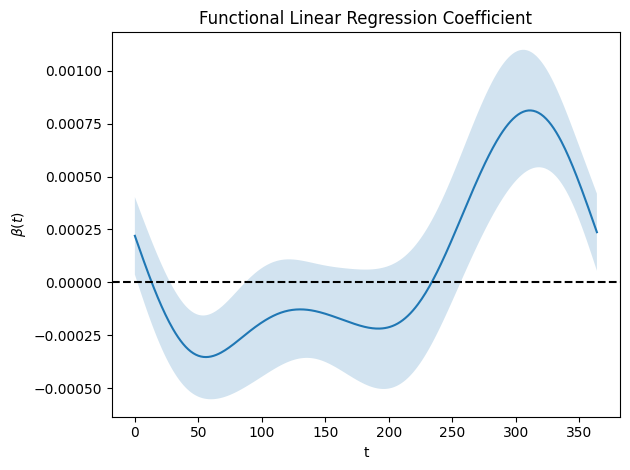

In [28]:
# Create an array consisting of the days in the year as defined by the basis.
day_array = np.linspace(*beta_fourier_basis.domain_range[0], 365)

# Evaluate the basis functions at each day of the year.
Phi = beta_fourier_basis(day_array)
Phi = Phi[..., 0] # Shape: (5, 365)

# Take the appropriate linear combination as defined above.
beta_values = zeta_hat[1:] @ Phi

# Add and subtract the confidence values above.
lower_beta_values = beta_values - 1.96 * np.sqrt(np.diag(Phi.T @ var_zeta @ Phi))
upper_beta_values = beta_values + 1.96 * np.sqrt(np.diag(Phi.T @ var_zeta @ Phi))

plt.figure()
plt.plot(day_array, beta_values)
# plt.plot(day_array, lower_beta_values, c="black")
# plt.plot(day_array, upper_beta_values, c="black")
plt.fill_between(day_array, lower_beta_values, upper_beta_values, alpha=0.2, label="95% pointwise CI")
plt.axhline(0, c="black", linestyle="--")
plt.xlabel("t")
plt.ylabel(r"$\beta(t)$")
plt.title("Functional Linear Regression Coefficient")
plt.tight_layout()
plt.show()

What does $X_{1}(t) \cdot \beta(t)$ look like? This is the function that is integrated and summed with $\alpha$ in the functional linear regression model.

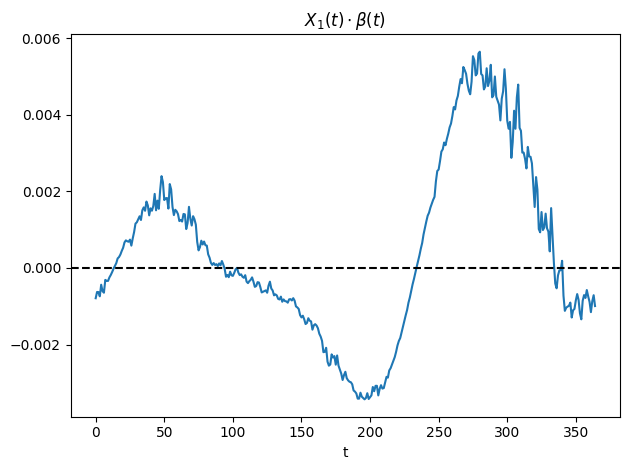

In [29]:
contributions = temps.data_matrix[0,:,0] * beta_values

plt.figure()
plt.plot(day_array, contributions)
plt.axhline(0, c="black", linestyle="--")
plt.xlabel("t")
# plt.ylabel(r"$\beta(t)$")
plt.title(r"$X_{1}(t) \cdot \beta(t)$")
plt.tight_layout()
plt.show()

### Fit assessment

We compute $R^{2}$ on the whole data set and the $F$-score.

In [30]:
prec_hat = Z @ zeta_hat
prec_res = prec - prec_hat

In [31]:
SS_tot = np.sum((prec - prec.mean())**2)
SS_res = np.sum(prec_res**2)

R2 = 1 - SS_res/SS_tot
R2

np.float64(0.7554358048908596)

In [32]:
F = ((SS_tot - SS_res) / 5) / (SS_res / (35 - 5 - 1))
F

np.float64(17.915654686949022)

### Remarks: C+ reproducibility

Things look close to the books! Coefficients are slightly off, but plots look very close. $R^{2}$ and $F$-score are also slightly off, the $F$-score more. I need to figure out whether I'm using the right matrix $R$ and also figure out the confidence intervals. I kinda hacked my way through, I need to actually sit down and figure out what's going on.

## Cross-validation

### Computations

We can choose the best smoothing parameter $\lambda$ using leave-one-out cross validation, referred to as CV throughout. Let $S$ be the hat matrix that sends $y$ to $\hat{y}$ for a particular value of $\lambda$. Then

$$\text{CV}(\lambda) = \sum_{i=1}^{N} \left( \frac{y_{i} - \hat{y}_{i}}{1 - S_{ii}} \right)^{2}.$$

Let's compute CV scores for various lambda values, spaced logarithmically.

In [33]:
# Define the grid of lambda values.
lambda_low = 5.5
lambda_high = 14.5
range_values = np.arange(lambda_low, lambda_high, 0.25)
lambda_values = 10**range_values

# For each, compute the CV score.
scores = {} # Empty dict to score lambdas and scores
for lam in lambda_values:
    S = Z @ np.linalg.inv(Z.T @ Z + lam * R_0) @ Z.T
    # S1 = Z @ np.linalg.inv(Z.T @ Z) @ Z.T
    diags = np.diag(S)
    prec_hat_lam = S @ prec
    prec_res_lam = prec - prec_hat_lam
    
    scores[lam] = ((prec_res_lam / (1 - diags))**2).sum()

### Plots

First, $\text{CV}(\lambda)$.

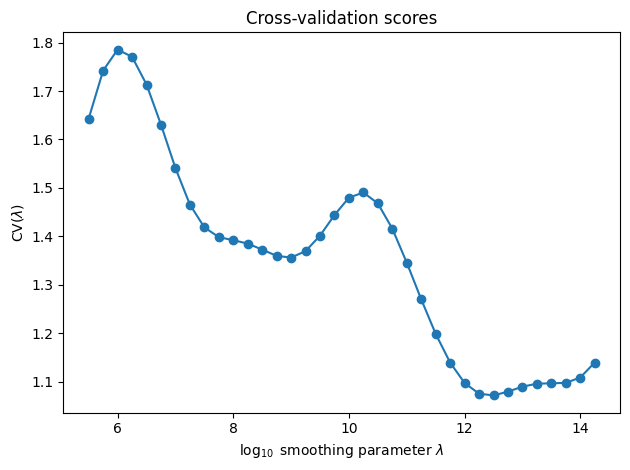

In [34]:
plt.figure()
plt.plot(range_values, scores.values(), marker="o")
plt.xlabel(r"$\log_{10}$ smoothing parameter $\lambda$")
plt.ylabel(r"$\text{CV}(\lambda)$")
plt.title("Cross-validation scores")
plt.tight_layout()
plt.show()

The plot looks similar to the book!

Now, deleted residuals:

$$\frac{y_{i} - \hat{y}_{i}}{1 - S_{ii}}.$$

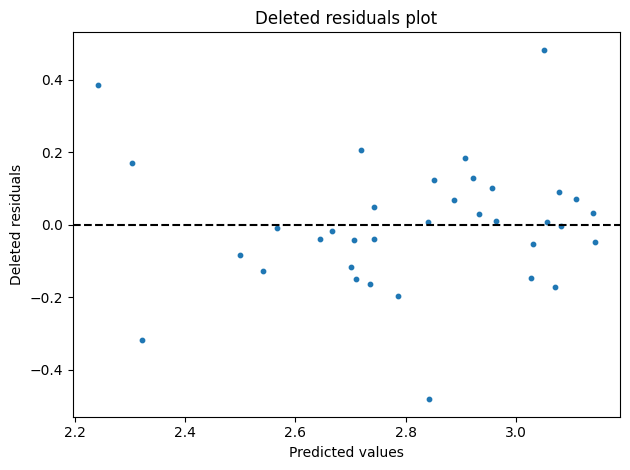

In [35]:
lam = 10**12.5
S = Z @ np.linalg.inv(Z.T @ Z + lam * R_0) @ Z.T
diags = np.diag(S)
prec_hat_lam = S @ prec
prec_res_lam = prec - prec_hat_lam

prec_del_res_lam = prec_res_lam / (1 - diags)

plt.figure()
plt.scatter(prec_hat_lam, prec_del_res_lam, s=10)
plt.axhline(0, c="black", linestyle="--")
plt.xlabel("Predicted values")
plt.ylabel("Deleted residuals")
plt.title("Deleted residuals plot")
plt.tight_layout()
plt.show()

The plot looks the same as the book's! Note that the predicted value scale is different since we're using $\log_{10}$ for *prec* instead of $\ln$.

### Remarks: A- reproducibility

Things look close to the books! Deleted residuals look very similar. Cross-validation is slightly off, but that's probably due to the coefficients being slightly different from those in R.

Two critiques of the book start to surface:
1. The CV plot looks to decrease on the very left, so are we missing something for low values of $\lambda$? Later, we extend the plot to $\lambda = 0$ and see that we're missing some of the picture here.
2. They don't actually use the harmonic acceleration penalty. Everything here mirrors the book more-or-less, but we're using just a squared second derivative penalty. Later on, we'll analyze the harmonic acceleration penalty.

## Scalar response models by functional principal components

We skip this for now.

## Appendix A: better $\lambda$ values

As mentioned above, the choice of $\lambda = 10^{12.5}$ is indeed at a CV $(\lambda)$ local minimum, but can we do better? First, let's recompute CV with a wider range of $\lambda$ values.

In [61]:
L = 365
omegas = [0] + [((((k+1)//2) / L)**4) for k in range(1, 35)]
R = np.diag(omegas)
R_0 = np.concatenate((np.zeros((35, 1)), R), axis=1)
R_0 = np.concatenate((np.zeros((1, 36)), R_0), axis=0)

In [62]:
# Define the grid of lambda values.
lambda_low = 0
lambda_high = 20
range_values = np.arange(lambda_low, lambda_high, 0.25)
lambda_values = 10**range_values

# For each, compute the CV score.
scores = {} # Empty dict to score lambdas and scores
for lam in lambda_values:
    S = Z @ np.linalg.inv(Z.T @ Z + lam * R_0) @ Z.T
    # S1 = Z @ np.linalg.inv(Z.T @ Z) @ Z.T
    diags = np.diag(S)
    prec_hat_lam = S @ prec
    prec_res_lam = prec - prec_hat_lam
    
    scores[lam] = ((prec_res_lam / (1 - diags))**2).sum()

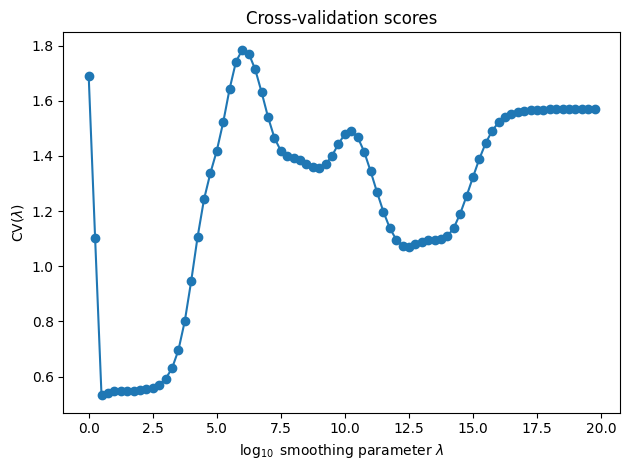

In [63]:
plt.figure()
plt.plot(range_values, scores.values(), marker="o")
plt.xlabel(r"$\log_{10}$ smoothing parameter $\lambda$")
plt.ylabel(r"$\text{CV}(\lambda)$")
plt.title("Cross-validation scores")
plt.tight_layout()
plt.show()

We can see local minima at $10^{9}$, $10^{12.5}$ as before, but now we also have a global minimum at $10^{0.5}$! Let's examine the coefficient functional $\beta(t)$ and corresponding overall and predictive $R^{2}$ scores at each of these values.

Recall, for LOOCV, predictive $R^{2}$ can be found by

$$R_{pred}^{2} = 1 - \frac{\sum_{i=1}^{n} (y_{i} - \hat{y}_{i}^{(-i)})}{SS_{T}}.$$

### $\lambda = 10^{12.5}$

In [39]:
lam = 10**12.5

zeta_hat = np.linalg.inv(Z.T @ Z + lam * R_0) @ Z.T @ prec

hat_matrix = Z @ np.linalg.inv(Z.T @ Z + lam * R_0) @ Z.T
df = np.linalg.trace(hat_matrix)

print("Degrees of freedom:", round(df, 1))
print()

SS_tot = np.sum((prec - prec.mean())**2)
prec_hat = hat_matrix @ prec
prec_res = prec - prec_hat
SS_res = np.sum(prec_res**2)

R2 = 1 - SS_res/SS_tot
print("R^2:", round(R2, 2))

S = Z @ np.linalg.inv(Z.T @ Z + lam * R_0) @ Z.T
diags = np.diag(S)
prec_hat_lam = S @ prec
prec_res_lam = prec - prec_hat_lam
prec_del_res_lam = prec_res_lam / (1 - diags)

R2_pred = 1 - (prec_del_res_lam**2).sum() / SS_tot
print("Predictive R^2:", round(R2_pred, 2))

Degrees of freedom: 4.7

R^2: 0.76
Predictive R^2: 0.61


In [66]:
# Define lambda.
lam = 10**12.5

# Solve for the coefficients.
A = Z.T @ Z + lam * R_0
zeta_hat = np.linalg.solve(A, Z.T @ prec)

# Fitted values.
prec_hat = Z @ zeta_hat
prec_res = prec - prec_hat

# In-sample R^2.
SS_tot = np.sum((prec - prec.mean())**2)
SS_res = np.sum(prec_res**2)
R2 = 1 - SS_res / SS_tot

# Build S only once.
S = Z @ np.linalg.solve(A, Z.T)
df = np.trace(S)

# LOOCV predictive R^2.
S_ii = np.diag(S)
den = 1.0 - S_ii
if np.min(np.abs(den)) < 1e-10:
    print("Warning: 1-S_ii tiny; LOOCV unstable.")

loocv_res = prec_res / den
R2_pred = 1 - np.sum(loocv_res**2) / SS_tot

print("Degrees of freedom:", round(df, 1))
print("R^2:", round(R2, 2))
print("Predictive R^2:", round(R2_pred, 2))

Degrees of freedom: 4.7
R^2: 0.76
Predictive R^2: 0.61


In [40]:
prec_hat = Z @ zeta_hat
prec_res = prec - prec_hat

rss = np.sum(prec_res**2)
sigma2e = rss / (len(prec) - df)

var_zeta = sigma2e * np.linalg.inv(Z.T @ Z + lam * R_0) @ Z.T @ Z @ np.linalg.inv(Z.T @ Z + lam * R_0)
var_zeta = var_zeta[1:, 1:]

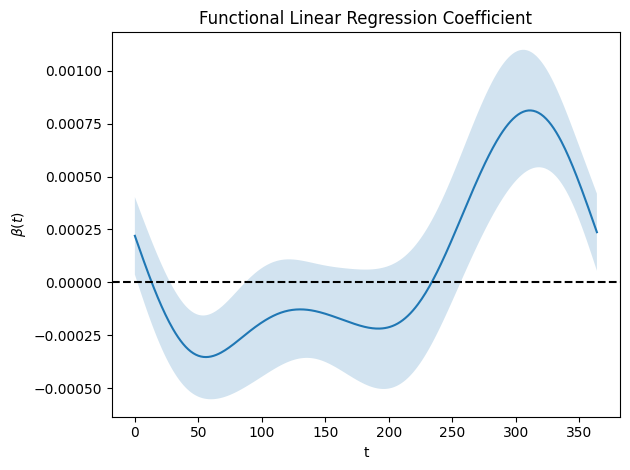

In [41]:
# Create an array consisting of the days in the year as defined by the basis.
day_array = np.linspace(*beta_fourier_basis.domain_range[0], 365)

# Evaluate the basis functions at each day of the year.
Phi = beta_fourier_basis(day_array)
Phi = Phi[..., 0] # Shape: (5, 365)

# Take the appropriate linear combination as defined above.
beta_values = zeta_hat[1:] @ Phi

# Add and subtract the confidence values above.
lower_beta_values = beta_values - 1.96 * np.sqrt(np.diag(Phi.T @ var_zeta @ Phi))
upper_beta_values = beta_values + 1.96 * np.sqrt(np.diag(Phi.T @ var_zeta @ Phi))

plt.figure()
plt.plot(day_array, beta_values)
# plt.plot(day_array, lower_beta_values, c="black")
# plt.plot(day_array, upper_beta_values, c="black")
plt.fill_between(day_array, lower_beta_values, upper_beta_values, alpha=0.2, label="95% pointwise CI")
plt.axhline(0, c="black", linestyle="--")
plt.xlabel("t")
plt.ylabel(r"$\beta(t)$")
plt.title("Functional Linear Regression Coefficient")
plt.tight_layout()
plt.show()

### $\lambda = 10^{9}$

In [42]:
lam = 10**9

zeta_hat = np.linalg.inv(Z.T @ Z + lam * R_0) @ Z.T @ prec

hat_matrix = Z @ np.linalg.inv(Z.T @ Z + lam * R_0) @ Z.T
df = np.linalg.trace(hat_matrix)

print("Degrees of freedom:", round(df, 1))
print()

SS_tot = np.sum((prec - prec.mean())**2)
prec_hat = hat_matrix @ prec
prec_res = prec - prec_hat
SS_res = np.sum(prec_res**2)

R2 = 1 - SS_res/SS_tot
print("R^2:", round(R2, 2))

S = Z @ np.linalg.inv(Z.T @ Z + lam * R_0) @ Z.T
diags = np.diag(S)
prec_hat_lam = S @ prec
prec_res_lam = prec - prec_hat_lam
prec_del_res_lam = prec_res_lam / (1 - diags)

R2_pred = 1 - (prec_del_res_lam**2).sum() / SS_tot
print("Predictive R^2:", round(R2_pred, 2))

Degrees of freedom: 11.8

R^2: 0.88
Predictive R^2: 0.51


In [ ]:
# Define lambda.
lam = 10**9

# Solve for the coefficients.
A = Z.T @ Z + lam * R_0
zeta_hat = np.linalg.solve(A, Z.T @ prec)

# Fitted values.
prec_hat = Z @ zeta_hat
prec_res = prec - prec_hat

# In-sample R^2.
SS_tot = np.sum((prec - prec.mean())**2)
SS_res = np.sum(prec_res**2)
R2 = 1 - SS_res / SS_tot

# Build S only once.
S = Z @ np.linalg.solve(A, Z.T)
df = np.trace(S)

# LOOCV predictive R^2.
S_ii = np.diag(S)
den = 1.0 - S_ii
if np.min(np.abs(den)) < 1e-10:
    print("Warning: 1-S_ii tiny; LOOCV unstable.")

loocv_res = prec_res / den
R2_pred = 1 - np.sum(loocv_res**2) / SS_tot












rss = np.sum(prec_res**2)
sigma2e = rss / (len(prec) - df)

var_zeta = sigma2e * np.linalg.inv(Z.T @ Z + lam * R_0) @ Z.T @ Z @ np.linalg.inv(Z.T @ Z + lam * R_0)
var_zeta = var_zeta[1:, 1:]

print("Degrees of freedom:", round(df, 1))
print("R^2:", round(R2, 2))
print("Predictive R^2:", round(R2_pred, 2))

Degrees of freedom: 11.8
R^2: 0.88
Predictive R^2: 0.51


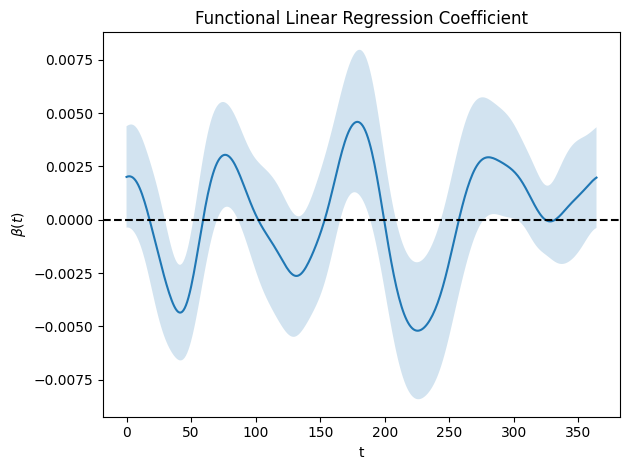

In [44]:
# Create an array consisting of the days in the year as defined by the basis.
day_array = np.linspace(*beta_fourier_basis.domain_range[0], 365)

# Evaluate the basis functions at each day of the year.
Phi = beta_fourier_basis(day_array)
Phi = Phi[..., 0] # Shape: (5, 365)

# Take the appropriate linear combination as defined above.
beta_values = zeta_hat[1:] @ Phi

# Add and subtract the confidence values above.
lower_beta_values = beta_values - 1.96 * np.sqrt(np.diag(Phi.T @ var_zeta @ Phi))
upper_beta_values = beta_values + 1.96 * np.sqrt(np.diag(Phi.T @ var_zeta @ Phi))

plt.figure()
plt.plot(day_array, beta_values)
# plt.plot(day_array, lower_beta_values, c="black")
# plt.plot(day_array, upper_beta_values, c="black")
plt.fill_between(day_array, lower_beta_values, upper_beta_values, alpha=0.2, label="95% pointwise CI")
plt.axhline(0, c="black", linestyle="--")
plt.xlabel("t")
plt.ylabel(r"$\beta(t)$")
plt.title("Functional Linear Regression Coefficient")
plt.tight_layout()
plt.show()

### $\lambda = 10^{0.5}$

In [45]:
lam = 10**0.5

zeta_hat = np.linalg.inv(Z.T @ Z + lam * R_0) @ Z.T @ prec

hat_matrix = Z @ np.linalg.inv(Z.T @ Z + lam * R_0) @ Z.T
df = np.linalg.trace(hat_matrix)

print("Degrees of freedom:", round(df, 1))
print()

SS_tot = np.sum((prec - prec.mean())**2)
prec_hat = hat_matrix @ prec
prec_res = prec - prec_hat
SS_res = np.sum(prec_res**2)

R2 = 1 - SS_res/SS_tot
print("R^2:", round(R2, 2))

S = Z @ np.linalg.inv(Z.T @ Z + lam * R_0) @ Z.T
diags = np.diag(S)
prec_hat_lam = S @ prec
prec_res_lam = prec - prec_hat_lam
prec_del_res_lam = prec_res_lam / (1 - diags)

R2_pred = 1 - (prec_del_res_lam**2).sum() / SS_tot
print("Predictive R^2:", round(R2_pred, 2))

Degrees of freedom: 35.0

R^2: 1.0
Predictive R^2: 0.81


In [71]:
# Define lambda.
lam = 10**0.5

# Solve for the coefficients.
A = Z.T @ Z + lam * R_0
zeta_hat = np.linalg.solve(A, Z.T @ prec)

# Fitted values.
prec_hat = Z @ zeta_hat
prec_res = prec - prec_hat

# In-sample R^2.
SS_tot = np.sum((prec - prec.mean())**2)
SS_res = np.sum(prec_res**2)
R2 = 1 - SS_res / SS_tot

# Build S only once.
S = Z @ np.linalg.solve(A, Z.T)
df = np.trace(S)

# LOOCV predictive R^2.
S_ii = np.diag(S)
den = 1.0 - S_ii
if np.min(np.abs(den)) < 1e-10:
    print("Warning: 1-S_ii tiny; LOOCV unstable.")

loocv_res = prec_res / den
R2_pred = 1 - np.sum(loocv_res**2) / SS_tot

print("Degrees of freedom:", round(df, 1))
print("R^2:", round(R2, 2))
print("Predictive R^2:", round(R2_pred, 2))

Degrees of freedom: 35.0
R^2: 1.0
Predictive R^2: 0.8


In [72]:
prec_hat = Z @ zeta_hat
prec_res = prec - prec_hat

rss = np.sum(prec_res**2)
sigma2e = rss / (len(prec) - df)

var_zeta = sigma2e * np.linalg.inv(Z.T @ Z + lam * R_0) @ Z.T @ Z @ np.linalg.inv(Z.T @ Z + lam * R_0)
var_zeta = var_zeta[1:, 1:]

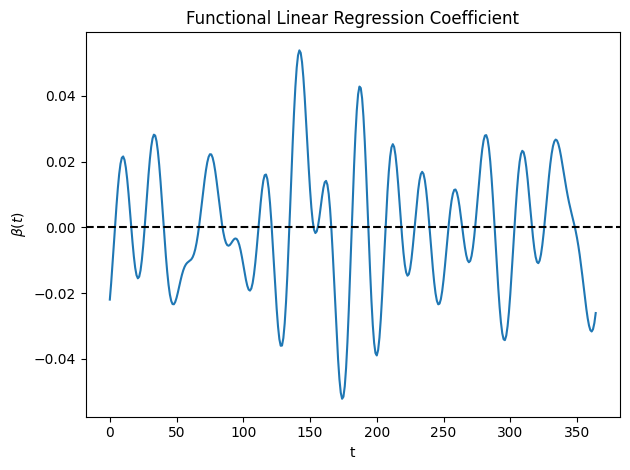

In [73]:
# Create an array consisting of the days in the year as defined by the basis.
day_array = np.linspace(*beta_fourier_basis.domain_range[0], 365)

# Evaluate the basis functions at each day of the year.
Phi = beta_fourier_basis(day_array)
Phi = Phi[..., 0] # Shape: (5, 365)

# Take the appropriate linear combination as defined above.
beta_values = zeta_hat[1:] @ Phi

# Add and subtract the confidence values above.
lower_beta_values = beta_values - 1.96 * np.sqrt(np.diag(Phi.T @ var_zeta @ Phi))
upper_beta_values = beta_values + 1.96 * np.sqrt(np.diag(Phi.T @ var_zeta @ Phi))

plt.figure()
plt.plot(day_array, beta_values)
# plt.plot(day_array, lower_beta_values, c="black")
# plt.plot(day_array, upper_beta_values, c="black")
plt.fill_between(day_array, lower_beta_values, upper_beta_values, alpha=0.2, label="95% pointwise CI")
plt.axhline(0, c="black", linestyle="--")
plt.xlabel("t")
plt.ylabel(r"$\beta(t)$")
plt.title("Functional Linear Regression Coefficient")
plt.tight_layout()
plt.show()

### $\lambda = 0$ (OLS)

In [48]:
lam = 0

zeta_hat = np.linalg.inv(Z.T @ Z + lam * R_0) @ Z.T @ prec

hat_matrix = Z @ np.linalg.inv(Z.T @ Z + lam * R_0) @ Z.T
df = np.linalg.trace(hat_matrix)

print("Degrees of freedom:", round(df, 1))
print()

SS_tot = np.sum((prec - prec.mean())**2)
prec_hat = hat_matrix @ prec
prec_res = prec - prec_hat
SS_res = np.sum(prec_res**2)

R2 = 1 - SS_res/SS_tot
print("R^2:", round(R2, 2))

S = Z @ np.linalg.inv(Z.T @ Z + lam * R_0) @ Z.T
diags = np.diag(S)
prec_hat_lam = S @ prec
prec_res_lam = prec - prec_hat_lam
prec_del_res_lam = prec_res_lam / (1 - diags)

R2_pred = 1 - (prec_del_res_lam**2).sum() / SS_tot
print("Predictive R^2:", round(R2_pred, 2))

Degrees of freedom: -208.4

R^2: -3739861.03
Predictive R^2: -10487631.38


In [69]:
# Define lambda.
lam = 0

# Solve for the coefficients.
A = Z.T @ Z + lam * R_0
zeta_hat = np.linalg.solve(A, Z.T @ prec)

# Fitted values.
prec_hat = Z @ zeta_hat
prec_res = prec - prec_hat

# In-sample R^2.
SS_tot = np.sum((prec - prec.mean())**2)
SS_res = np.sum(prec_res**2)
R2 = 1 - SS_res / SS_tot

# Build S only once.
S = Z @ np.linalg.solve(A, Z.T)
df = np.trace(S)

# LOOCV predictive R^2.
S_ii = np.diag(S)
den = 1.0 - S_ii
if np.min(np.abs(den)) < 1e-10:
    print("Warning: 1-S_ii tiny; LOOCV unstable.")

loocv_res = prec_res / den
R2_pred = 1 - np.sum(loocv_res**2) / SS_tot

print("Degrees of freedom:", round(df, 1))
print("R^2:", round(R2, 2))
print("Predictive R^2:", round(R2_pred, 2))

Degrees of freedom: 35.0
R^2: 1.0
Predictive R^2: -108.73


Note how this is a perfect fit! We're using 35 basis functions for $\beta$ when we have only 35 functional observations, so we're perfectly interpolating the data.

In [49]:
prec_hat = Z @ zeta_hat
prec_res = prec - prec_hat

rss = np.sum(prec_res**2)
sigma2e = rss / (len(prec) - df)

var_zeta = sigma2e * np.linalg.inv(Z.T @ Z + lam * R_0) @ Z.T @ Z @ np.linalg.inv(Z.T @ Z + lam * R_0)
var_zeta = var_zeta[1:, 1:]

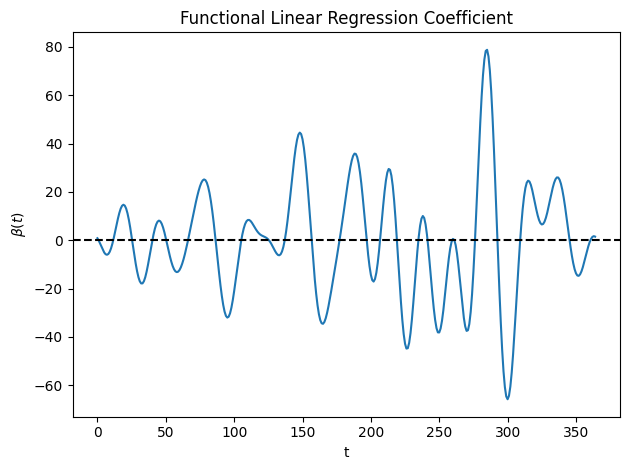

In [50]:
# Create an array consisting of the days in the year as defined by the basis.
day_array = np.linspace(*beta_fourier_basis.domain_range[0], 365)

# Evaluate the basis functions at each day of the year.
Phi = beta_fourier_basis(day_array)
Phi = Phi[..., 0] # Shape: (5, 365)

# Take the appropriate linear combination as defined above.
beta_values = zeta_hat[1:] @ Phi

# Add and subtract the confidence values above.
lower_beta_values = beta_values - 1.96 * np.sqrt(np.diag(Phi.T @ var_zeta @ Phi))
upper_beta_values = beta_values + 1.96 * np.sqrt(np.diag(Phi.T @ var_zeta @ Phi))

plt.figure()
plt.plot(day_array, beta_values)
# plt.plot(day_array, lower_beta_values, c="black")
# plt.plot(day_array, upper_beta_values, c="black")
# plt.fill_between(day_array, lower_beta_values, upper_beta_values, alpha=0.2, label="95% pointwise CI")
plt.axhline(0, c="black", linestyle="--")
plt.xlabel("t")
plt.ylabel(r"$\beta(t)$")
plt.title("Functional Linear Regression Coefficient")
plt.tight_layout()
plt.show()

### $\lambda = 10^{10.5}$ (local maximum)

What if we use a value known to be bad? This value is at a local maximum for the CV function.

In [51]:
lam = 10**10.5

zeta_hat = np.linalg.inv(Z.T @ Z + lam * R_0) @ Z.T @ prec

hat_matrix = Z @ np.linalg.inv(Z.T @ Z + lam * R_0) @ Z.T
df = np.linalg.trace(hat_matrix)

print("Degrees of freedom:", round(df, 1))
print()

SS_tot = np.sum((prec - prec.mean())**2)
SS_res = np.sum(prec_res**2)

R2 = 1 - SS_res/SS_tot
print("R^2:", round(R2, 2))

S = Z @ np.linalg.inv(Z.T @ Z + lam * R_0) @ Z.T
diags = np.diag(S)
prec_hat_lam = S @ prec
prec_res_lam = prec - prec_hat_lam
prec_del_res_lam = prec_res_lam / (1 - diags)

R2_pred = 1 - (prec_del_res_lam**2).sum() / SS_tot
print("Predictive R^2:", round(R2_pred, 2))

Degrees of freedom: 7.6

R^2: -1924123.98
Predictive R^2: 0.47


In [70]:
# Define lambda.
lam = 10**10.5

# Solve for the coefficients.
A = Z.T @ Z + lam * R_0
zeta_hat = np.linalg.solve(A, Z.T @ prec)

# Fitted values.
prec_hat = Z @ zeta_hat
prec_res = prec - prec_hat

# In-sample R^2.
SS_tot = np.sum((prec - prec.mean())**2)
SS_res = np.sum(prec_res**2)
R2 = 1 - SS_res / SS_tot

# Build S only once.
S = Z @ np.linalg.solve(A, Z.T)
df = np.trace(S)

# LOOCV predictive R^2.
S_ii = np.diag(S)
den = 1.0 - S_ii
if np.min(np.abs(den)) < 1e-10:
    print("Warning: 1-S_ii tiny; LOOCV unstable.")

loocv_res = prec_res / den
R2_pred = 1 - np.sum(loocv_res**2) / SS_tot

print("Degrees of freedom:", round(df, 1))
print("R^2:", round(R2, 2))
print("Predictive R^2:", round(R2_pred, 2))

Degrees of freedom: 7.6
R^2: 0.82
Predictive R^2: 0.47


In [52]:
prec_hat = Z @ zeta_hat
prec_res = prec - prec_hat

rss = np.sum(prec_res**2)
sigma2e = rss / (len(prec) - df)

var_zeta = sigma2e * np.linalg.inv(Z.T @ Z + lam * R_0) @ Z.T @ Z @ np.linalg.inv(Z.T @ Z + lam * R_0)
var_zeta = var_zeta[1:, 1:]

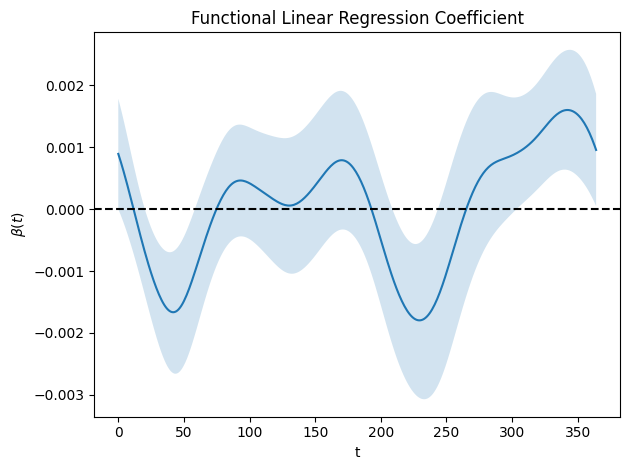

In [53]:
# Create an array consisting of the days in the year as defined by the basis.
day_array = np.linspace(*beta_fourier_basis.domain_range[0], 365)

# Evaluate the basis functions at each day of the year.
Phi = beta_fourier_basis(day_array)
Phi = Phi[..., 0] # Shape: (5, 365)

# Take the appropriate linear combination as defined above.
beta_values = zeta_hat[1:] @ Phi

# Add and subtract the confidence values above.
lower_beta_values = beta_values - 1.96 * np.sqrt(np.diag(Phi.T @ var_zeta @ Phi))
upper_beta_values = beta_values + 1.96 * np.sqrt(np.diag(Phi.T @ var_zeta @ Phi))

plt.figure()
plt.plot(day_array, beta_values)
# plt.plot(day_array, lower_beta_values, c="black")
# plt.plot(day_array, upper_beta_values, c="black")
plt.fill_between(day_array, lower_beta_values, upper_beta_values, alpha=0.2, label="95% pointwise CI")
plt.axhline(0, c="black", linestyle="--")
plt.xlabel("t")
plt.ylabel(r"$\beta(t)$")
plt.title("Functional Linear Regression Coefficient")
plt.tight_layout()
plt.show()

Overall $R^{2}$ matches those of the other $\lambda$ values around it, but we lose some interpretibility. The CV score also suggests we would introduce some generalization error when using a train-test split.

### Remarks: $\lambda = 10^{12.5}$ wins

The larger values of $\lambda$ give similar $R^{2}$ around $0.76$, while $\lambda = 10^{0.5}$ yields $R^{2} = 0.88$. However, the value of $\lambda = 10^{12.5}$ eats up the fewest degrees of freedom by far and yields the most interpretable coefficient function, so this is the value which we choose.

## Appendix B: harmonic acceleration penalty

The work above and in the books actually don't use harmonic acceleration, just the second derivative. We want to examine what actually happens when using this penalty term.

### Penalty computations

In [54]:
import numpy as np

def fourier_R_harmaccel(n_basis: int, domain_range, omega0=None):
    """
    Harmonic-acceleration penalty matrix for a Fourier basis:
        R_kl = ∫ (L φ_k)(t) (L φ_l)(t) dt
    with L = D^3 + omega0^2 D.

    Parameters
    ----------
    n_basis : int
        Number of Fourier basis functions.
    domain_range : tuple (a,b) or list [(a,b)]
        Domain of the basis.
    omega0 : float or None
        The omega0 used in L = D^3 + omega0^2 D.
        If None, uses omega0 = 2π / L (the fda default).

    Returns
    -------
    R : (n_basis, n_basis) ndarray, diagonal
    """
    # accept (a,b) or [(a,b)]
    if isinstance(domain_range, (list, tuple)) and len(domain_range) == 1 and isinstance(domain_range[0], (list, tuple)):
        a, b = domain_range[0]
    else:
        a, b = domain_range

    L = b - a
    if omega0 is None:
        omega0 = 2.0 * np.pi / L

    R = np.zeros((n_basis, n_basis), dtype=float)

    # k=0 constant term -> Lφ = 0 -> no penalty
    for k in range(1, n_basis):
        r = (k + 1) // 2              # k=1,2 -> 1; k=3,4 -> 2; ...
        omega_r = 2.0 * np.pi * r / L
        R[k, k] = (L / 2.0) * (omega_r**2) * ((omega_r**2 - omega0**2)**2)

    return R


In [55]:
R = fourier_R_harmaccel(beta_fourier_basis.n_basis, (0, 364))
R_0 = np.concatenate((np.zeros((35, 1)), R), axis=1)
R_0 = np.concatenate((np.zeros((1, 36)), R_0), axis=0)

### Cross-validation selection

In [56]:
# Define the grid of lambda values.
lambda_low = 0
lambda_high = 20
range_values = np.arange(lambda_low, lambda_high, 0.25)
lambda_values = 10**range_values

# For each, compute the CV score.
scores = {} # Empty dict to score lambdas and scores
for lam in lambda_values:
    S = Z @ np.linalg.inv(Z.T @ Z + lam * R_0) @ Z.T
    # S1 = Z @ np.linalg.inv(Z.T @ Z) @ Z.T
    diags = np.diag(S)
    prec_hat_lam = S @ prec
    prec_res_lam = prec - prec_hat_lam
    
    scores[lam] = ((prec_res_lam / (1 - diags))**2).sum()

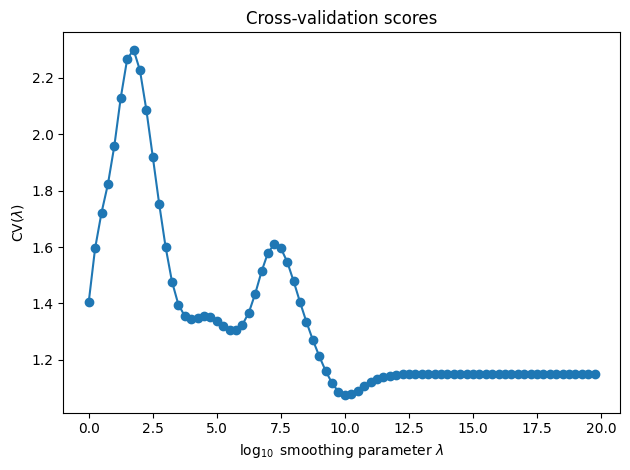

In [57]:
plt.figure()
plt.plot(range_values, scores.values(), marker="o")
plt.xlabel(r"$\log_{10}$ smoothing parameter $\lambda$")
plt.ylabel(r"$\text{CV}(\lambda)$")
plt.title("Cross-validation scores")
plt.tight_layout()
plt.show()

It looks like now we should use $\lambda = 10^{10}$!

### $\lambda = 10^{10}$

In [58]:
lam = 10**10

zeta_hat = np.linalg.inv(Z.T @ Z + lam * R_0) @ Z.T @ prec

hat_matrix = Z @ np.linalg.inv(Z.T @ Z + lam * R_0) @ Z.T
df = np.linalg.trace(hat_matrix)

print("Degrees of freedom:", round(df, 1))
print()

SS_tot = np.sum((prec - prec.mean())**2)
SS_res = np.sum(prec_res**2)

R2 = 1 - SS_res/SS_tot
print("R^2:", round(R2, 2))

S = Z @ np.linalg.inv(Z.T @ Z + lam * R_0) @ Z.T
diags = np.diag(S)
prec_hat_lam = S @ prec
prec_res_lam = prec - prec_hat_lam
prec_del_res_lam = prec_res_lam / (1 - diags)

R2_pred = 1 - (prec_del_res_lam**2).sum() / SS_tot
print("Predictive R^2:", round(R2_pred, 2))

Degrees of freedom: 4.9

R^2: 0.82
Predictive R^2: 0.61


Recall our best fit using the curvature penalty: $R^{2} = 0.74$ using 4.7 degrees of freedom. This gives a better fit using around the same df!

In [59]:
prec_hat = Z @ zeta_hat
prec_res = prec - prec_hat

rss = np.sum(prec_res**2)
sigma2e = rss / (len(prec) - df)

var_zeta = sigma2e * np.linalg.inv(Z.T @ Z + lam * R_0) @ Z.T @ Z @ np.linalg.inv(Z.T @ Z + lam * R_0)
var_zeta = var_zeta[1:, 1:]

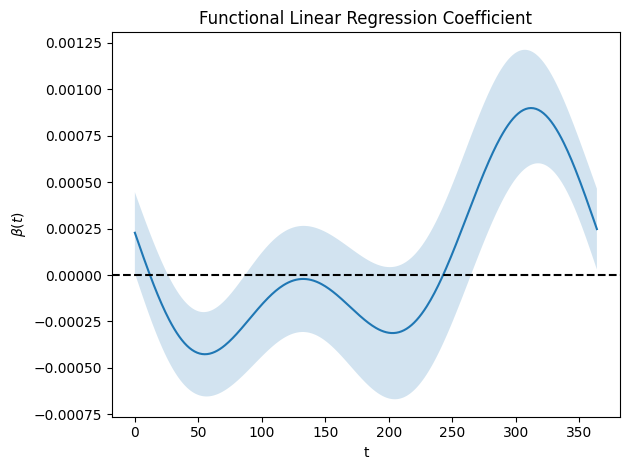

In [60]:
# Create an array consisting of the days in the year as defined by the basis.
day_array = np.linspace(*beta_fourier_basis.domain_range[0], 365)

# Evaluate the basis functions at each day of the year.
Phi = beta_fourier_basis(day_array)
Phi = Phi[..., 0] # Shape: (5, 365)

# Take the appropriate linear combination as defined above.
beta_values = zeta_hat[1:] @ Phi

# Add and subtract the confidence values above.
lower_beta_values = beta_values - 1.96 * np.sqrt(np.diag(Phi.T @ var_zeta @ Phi))
upper_beta_values = beta_values + 1.96 * np.sqrt(np.diag(Phi.T @ var_zeta @ Phi))

plt.figure()
plt.plot(day_array, beta_values)
# plt.plot(day_array, lower_beta_values, c="black")
# plt.plot(day_array, upper_beta_values, c="black")
plt.fill_between(day_array, lower_beta_values, upper_beta_values, alpha=0.2, label="95% pointwise CI")
plt.axhline(0, c="black", linestyle="--")
plt.xlabel("t")
plt.ylabel(r"$\beta(t)$")
plt.title("Functional Linear Regression Coefficient")
plt.tight_layout()
plt.show()

This actually gives us a very similar function as before, except the early summer months' contributions are much closer to zero.

# TODO:

Figure out why running cells in different orders changes results. Specifically, in Appendix A. Probably didn't define residuals or something every time.